In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import scipy.io as sio
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import torch
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, savgol_filter, butter, filtfilt
from torch.utils.data import Dataset, DataLoader

In [2]:
def segment_insole_data(insole_data):
    toe_region = insole_data[:, :13, :]  # Toe
    forefoot_region = insole_data[:, 13:31, :]  # Forefoot
    midfoot_region = insole_data[:, 32:42, :]  #  Midfoot
    heel_region = insole_data[:, 42:, :]  #  Heel
    return heel_region, midfoot_region, forefoot_region, toe_region

def butter_lowpass_filter(data, cutoff=8, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def reshape_insole_grid(data):
    num_frames = data.shape[0]
    reshaped_data = np.empty((num_frames, 64, 16), dtype=data.dtype)
    for i in range(num_frames):
        frame = data[i].reshape(16, 64).T.copy()
        frame[:32, :] = np.flipud(frame[:32, :])
        reshaped_data[i] = frame

    return reshaped_data

def gait_segmentation(insole, h_th, t_th, ms_th):

    insole = reshape_insole_grid(insole)
    heel_region, midfoot_region, forefoot_region, toe_region = segment_insole_data(insole)
    p_heel = np.mean(heel_region, axis=(1, 2))
    p_toe = np.mean(toe_region, axis=(1, 2))
    p_forefoot = np.mean(forefoot_region, axis=(1, 2))
    p_insole = (insole > 25).astype(int)

    p_heel_filtered = butter_lowpass_filter(p_heel, 8, 75)
    p_fore_filtered = butter_lowpass_filter(p_forefoot+p_toe, 8, 75)
    p_foot_filtered = butter_lowpass_filter(np.sum(insole, axis=(1, 2)), 8, 75)
    plt.figure()

    plt.plot(p_foot_filtered, label = "foot")
    plt.plot(p_fore_filtered, label = "fore")
    plt.plot(p_heel_filtered, label = "heel")
    plt.xlim(300, 700)
    plt.legend()

    p_heel_derivative = np.gradient(p_heel_filtered)
    p_fore_derivative = np.gradient(p_fore_filtered)

    hc_indices, _ = find_peaks(p_heel_derivative, height=h_th, distance=10)
    to_indices, _ = find_peaks(-p_fore_derivative, height=t_th, distance=10)
    ms_indices, _ = find_peaks(p_foot_filtered, height=ms_th, distance=10)
    
    return hc_indices, to_indices, ms_indices



def resample_data(data):
    n = data.shape[0]
    index = np.linspace(0, 100, n)
    target = np.linspace(0, 100, 100)
    resampled_data = np.zeros((100, 3))
    for i in range(3):
        interp_func = interp1d(index, data[:, i])
        resampled_data[:, i] = interp_func(target)

    return resampled_data


def get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds):
    """
    Get gait parameters from insole data
    """

    [h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r] = thresholds

    gait = {'foot_trace_r': np.zeros(len(t_r)), 'foot_trace_l': np.zeros(len(t_l)),
            'dim': [int(np.sqrt(insole_r.shape[1]) * 2), int(np.sqrt(insole_r.shape[1]) / 2)],
            'cop_x_r': np.zeros(len(t_r)),
            'cop_y_r': np.zeros(len(t_r)),
            'cont_area_r': np.zeros(len(t_r)),
            'cop_x_l': np.zeros(len(t_l)),
            'cop_y_l': np.zeros(len(t_l)),
            'cont_area_l': np.zeros(len(t_l)),
            }
    insole_data = {'insole_r_flipped':[],
            'insole_l_flipped':[]}

    for i in range(len(t_r)):
        frame = insole_r[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        gait['foot_trace_r'][i] = np.mean(frame)
        insole_data['insole_r_flipped'].append(frame)
        x, y = np.where(frame > 0)

        # COP
        sum_frame_r = np.sum(frame[x, y])
        if sum_frame_r > 0:
            gait['cop_x_r'][i] = np.sum(x * frame[x, y]) / sum_frame_r
            gait['cop_y_r'][i] = np.sum(y * frame[x, y]) / sum_frame_r
        else:
            gait['cop_x_r'][i] = np.nan
            gait['cop_y_r'][i] = np.nan

        gait['cont_area_r'][i] = len(x)


    for i in range(len(t_l)):
        frame = insole_l[i, :].reshape(gait['dim'][0], gait['dim'][1], order='F')
        frame[:gait['dim'][0] // 2, :] = np.flipud(frame[:gait['dim'][0] // 2, :])
        insole_data['insole_l_flipped'].append(frame)
        gait['foot_trace_l'][i] = np.mean(insole_l[i,:])


    # Gait events
    hc_indices, to_indices, ms_indices = gait_segmentation(insole_r, h_th_r, t_th_r, ms_th_r)
    strike_r = hc_indices
    off_r = to_indices
    ms_r = ms_indices

    hc_indices, to_indices, ms_indices = gait_segmentation(insole_l, h_th_l, t_th_l, ms_th_l)
    strike_l = hc_indices
    off_l = to_indices
    ms_l = ms_indices

    # Isolate complete gait cycles
    gait['step_r'] = []
    gait['step_l'] = []
    for i in range(len(strike_r) - 1):
        start, end = strike_r[i], strike_r[i + 1]
        if t_r[end] - t_r[start] > strike_th_r:
            continue
        step_off = [o for o in off_r if start <= o <= end]
        ms = [j for j in ms_r if start <= j <= end]
        if len(step_off) == 1:
            gait['step_r'].append({'strike': [start, end], 'ms': ms,'off': step_off})

    for i in range(len(strike_l) - 1):
        start, end = strike_l[i], strike_l[i + 1]
        if t_l[end] - t_l[start] > strike_th_l:
            continue
        step_off = [o for o in off_l if start <= o <= end]
        ms = [j for j in ms_l if start <= j <= end]

        if len(step_off) == 1:
            gait['step_l'].append({'strike': [start, end], 'ms': ms, 'off': step_off})

    # Cycle duration
    gait['cycle_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['swing_dur_l']= np.zeros((len(gait['step_l'])))
    gait['stance_dur_l'] = np.zeros((len(gait['step_l'])))
    gait['cadence_l'] = np.zeros(len(gait['cycle_dur_l']))
    gait['cycle_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['swing_dur_r']= np.zeros((len(gait['step_r'])))
    gait['stance_dur_r'] = np.zeros((len(gait['step_r'])))
    gait['cadence_r'] = np.zeros(len(gait['cycle_dur_r']))

    for i in range((len(gait['step_l']))):
        start, end = gait['step_l'][i]['strike']
        off = gait['step_l'][i]['off']
        gait['cycle_dur_l'][i] = t_l[end] - t_l[start]
        gait['stance_dur_l'][i] = t_l[off] - t_l[start]
    gait['swing_dur_l'] = gait['cycle_dur_l'] - gait['stance_dur_l']
    gait['stance_phase_l'] = gait['stance_dur_l']/gait['cycle_dur_l']
    gait['swing_phase_l'] = gait['swing_dur_l'] / gait['cycle_dur_l']
    gait['cadence_l'] = 60/gait['cycle_dur_l']

    for i in range((len(gait['step_r']))):
        start, end = gait['step_r'][i]['strike']
        off = gait['step_r'][i]['off']
        gait['cycle_dur_r'][i] = t_r[end] - t_r[start]
        gait['stance_dur_r'][i] = t_r[off] - t_r[start]
    gait['swing_dur_r'] = gait['cycle_dur_r'] - gait['stance_dur_r']
    gait['stance_phase_r'] = gait['stance_dur_r']/gait['cycle_dur_r']
    gait['swing_phase_r'] = gait['swing_dur_r'] / gait['cycle_dur_r']
    gait['cadence_r'] = 60/gait['cycle_dur_r']

    gait['swing_asym'] = np.abs((np.mean(gait['swing_phase_l']) - np.mean(gait['swing_phase_r']))) / (
            0.5 * (np.mean(gait['swing_phase_l']) + np.mean(gait['swing_phase_r'])))

    return gait, insole_data

In [3]:
insole_data_path = Path("data")
insole_data = sio.loadmat(insole_data_path / "gait_recording_080624_walk2.mat")

In [4]:
print(insole_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'insoleAll_l', 'insoleAll_r', 'jnt_angles_all_l', 'jnt_angles_all_r', 'jnt_pos_all_l', 'jnt_pos_all_r', 'tAll_l', 'tAll_r', 't_insole_l', 't_insole_r', 't_trackers'])


In [5]:
insole_l = insole_data['insoleAll_l']
insole_r = insole_data['insoleAll_r']
t_l = insole_data['t_insole_l']
t_r = insole_data['t_insole_r']
thresholds = [30, 30, 30,30, 20000,20000, 2, 2] #[h_th_r, t_th_r, h_th_l, t_th_l, ms_th_r, ms_th_l, strike_th_l, strike_th_r] 

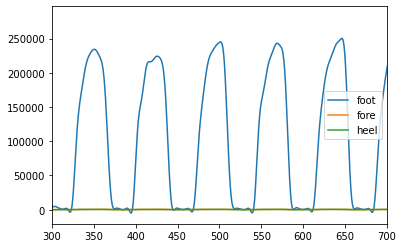

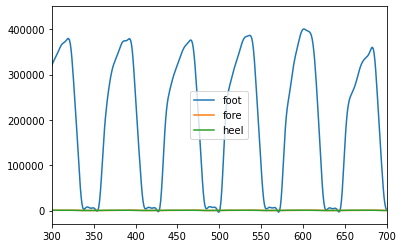

In [6]:
gait, insole_data = get_gait_parameters_insole2(insole_r, insole_l, t_r, t_l, thresholds)

In [7]:
# Extracting strike and off indices
strike_indices = [idx for step in gait['step_l'] for idx in step['strike']]
off_indices = [idx for step in gait['step_l'] for idx in step['off']]
ms_indices = [idx for step in gait['step_l'] for idx in step['ms']]

Text(0.5, 0, 'Frame indices')

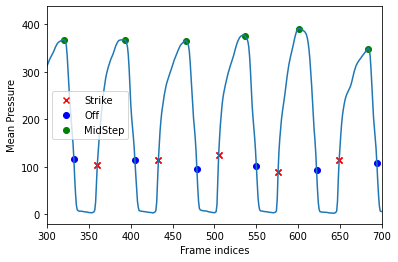

In [8]:
plt.plot(gait['foot_trace_l'])
# Plot 'strike' with 'x' markers
plt.scatter(strike_indices, [gait['foot_trace_l'][idx] for idx in strike_indices], 
            color='red', marker='x', label="Strike")

# Plot 'off' with 'o' markers
plt.scatter(off_indices, [gait['foot_trace_l'][idx] for idx in off_indices], 
            color='blue', marker='o', label="Off")

# Plot 'off' with 'o' markers
plt.scatter(ms_indices, [gait['foot_trace_l'][idx] for idx in ms_indices], 
            color='green', marker='o', label="MidStep")
plt.legend()
plt.xlim(300, 700)

plt.ylabel("Mean Pressure")
plt.xlabel("Frame indices")


In [9]:
def produce_slice(strike_indices, off_indices, ms_indices, insole_all):
    #double support from heel strike to mid stance
    
    ds_startend = list(zip(strike_indices, ms_indices))
    
    #single support from mid stance to toe off
    ss_startend = list(zip(ms_indices,off_indices))
    
    #swing from toe off to next heel strike
    swing_startend = list(zip(off_indices[:-1],strike_indices[1:]))
    
    ds_frames, ss_frames, swing_frames = [], [],[]
    
    for s,e in ds_startend: 
        ds_frames+=insole_all['insole_l_flipped'][s:e]
    for s,e in ss_startend: 
        ss_frames+=insole_all['insole_l_flipped'][s:e]
        
    for s,e in swing_startend: 
        swing_frames+=insole_all['insole_l_flipped'][s:e]
    

    
    return {"double":ds_frames, "single":ss_frames, "swing":swing_frames}

    
    
    
    

In [10]:
segments = produce_slice(strike_indices, off_indices, ms_indices, insole_data)